In [1]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
RANDOM_STATE = 69
TRAIN_SIZE = 105

In [2]:
cbr_filename = 'data.csv'
df = pd.read_csv(cbr_filename).drop(columns=['Unnamed: 0'])
df['Отчетная дата'] = pd.to_datetime(df['Отчетная дата'])

# Train

In [3]:
df['y'] = df['Просроченная задолженность по кредитам'].diff().shift(-1)
df

,Отчетная дата,Просроченная задолженность по кредитам,добыча полезных ископаемых,добыча топливно-энергетических полезных ископаемых,обрабатывающие производства,"производство пищевых продуктов, включая напитки, и табака",обработка древесины и производство изделий из дерева,целлюлозно-бумажное производство; издательская и полиграфическая деятельность,"производство кокса, нефтепродуктов и ядерных материалов",химическое производство,...,MIACR_от 181 дн. до 1 года,MOEX_Date,MOEX_Price,MOEX_Open,MOEX_High,MOEX_Low,MOEX_Change %,Date,Inflation,y
0,2009-04-01,346769,3084,1813,69830,23171,3464,1861,381,2475,...,13.47,2009-04-01,920.35,772.93,942.58,758.09,19.07,2009-04-01,13.16,33296.0
1,2009-05-01,380065,4032,1871,74435,24133,3711,1999,672,2615,...,16.33,2009-05-01,1123.38,935.16,1125.59,935.16,22.06,2009-05-01,12.28,29602.0
2,2009-06-01,409667,3235,1967,80603,24110,3984,2156,672,2989,...,11.04,2009-06-01,971.55,1142.63,1226.62,881.79,-13.52,2009-06-01,11.87,18783.0
3,2009-07-01,428450,5346,2732,89104,24647,4178,2046,1192,1587,...,0.00,2009-07-01,1053.30,974.23,1057.41,852.12,8.41,2009-07-01,12.01,49819.0
4,2009-08-01,478269,7519,2067,93343,22821,5309,3447,2056,1980,...,11.50,2009-08-01,1091.98,1059.29,1135.76,1013.82,3.67,2009-08-01,11.60,46498.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2022-09-01,3204919,192828,143727,734122,109687,12505,23908,111094,103326,...,0.00,2022-09-01,1957.31,2401.98,2492.15,1841.42,-18.45,2022-09-01,13.67,86086.0
162,2022-10-01,3291005,191972,141595,769237,112301,12642,23962,117724,105958,...,0.00,2022-10-01,2166.61,1991.88,2184.38,1775.04,10.69,2022-10-01,12.63,117875.0
163,2022-11-01,3408880,202082,147825,791008,114216,12727,24398,118648,108232,...,0.00,2022-11-01,2174.53,2179.15,2254.94,2123.32,0.37,2022-11-01,11.97,61435.0
164,2022-12-01,3470315,205046,150226,802172,115044,13313,24119,121362,110042,...,0.00,2022-12-01,2154.12,2189.65,2210.70,2070.58,-0.94,2022-12-01,11.92,68556.0


In [4]:
credit_cols = ['Просроченная задолженность по кредитам',
    #    'добыча полезных ископаемых',
    #    'добыча топливно-энергетических полезных ископаемых',
    #    'обрабатывающие производства',
    #    'производство пищевых продуктов, включая напитки, и табака',
    #    'обработка древесины и производство изделий из дерева',
    #    'целлюлозно-бумажное производство; издательская и полиграфическая деятельность',
    #    'производство кокса, нефтепродуктов и ядерных материалов',
    #    'химическое производство',
    #    'производство прочих неметаллических минеральных продуктов',
    #    'металлургическое производство и производство готовых металлических изделий',
    #    'производство машин и оборудования',
    #    'производство машин и оборудования для сельского и лесного хозяйства',
    #    'производство транспортных средств и оборудования',
    #    'производство автомобилей',
    #    'производство и распределение электроэнергии, газа и воды',
    #    'сельское хозяйство, охота и лесное хозяйство',
    #    'сельское хозяйство, охота и предоставление услуг в этих областях',
    #    'строительство', 'строительство зданий и сооружений',
    #    'транспорт и связь',
    #    'деятельность воздушного транспорта, подчиняющегося и не подчиняющегося расписанию',
    #    'оптовая и розничная торговля; ремонт автотранспортных средств, мотоциклов, бытовых изделий и предметов личного пользования',
    #    'операции с недвижимым имуществом, аренда и предоставление услуг',
    #    'прочие виды деятельности', 'на завершение расчетов',
    ]
for col in credit_cols:
    df['diff_' + col] = df[col].diff()
# df = df.drop(columns=credit_cols)

In [5]:
df.shape

(166, 44)

In [6]:
df.columns

Index(['Отчетная дата', 'Просроченная задолженность по кредитам',
       'добыча полезных ископаемых',
       'добыча топливно-энергетических полезных ископаемых',
       'обрабатывающие производства',
       'производство пищевых продуктов, включая напитки, и табака',
       'обработка древесины и производство изделий из дерева',
       'целлюлозно-бумажное производство; издательская и полиграфическая деятельность',
       'производство кокса, нефтепродуктов и ядерных материалов',
       'химическое производство',
       'производство прочих неметаллических минеральных продуктов',
       'металлургическое производство и производство готовых металлических изделий',
       'производство машин и оборудования',
       'производство машин и оборудования для сельского и лесного хозяйства',
       'производство транспортных средств и оборудования',
       'производство автомобилей',
       'производство и распределение электроэнергии, газа и воды',
       'сельское хозяйство, охота и лесное 

In [7]:
columns = ['MOEX_Price','MOEX_Open', 'MOEX_High', 'MOEX_Low', 'diff_Просроченная задолженность по кредитам']

for col_name in columns:
    for period in [2, 6, 12]:
        df[f"{col_name}_diff_{period}"] = df[col_name].shift(period) - df[col_name]
        df[f"{col_name}_median_{period}"] = df[col_name].rolling(period).median()
        df[f"{col_name}_std_{period}"] = df[col_name].rolling(period).std()
        df[f"{col_name}_max_{period}"] = df[col_name].rolling(period).max()
        df[f"{col_name}_min_{period}"] = df[col_name].rolling(period).min()
        df[f"{col_name}_quantile25_{period}"] = df[col_name].rolling(period).quantile(0.25)
        df[f"{col_name}_quantile75_{period}"] = df[col_name].rolling(period).quantile(0.75)


/tmp/ipykernel_631908/636612748.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col_name}_max_{period}"] = df[col_name].rolling(period).max()
/tmp/ipykernel_631908/636612748.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col_name}_min_{period}"] = df[col_name].rolling(period).min()
/tmp/ipykernel_631908/636612748.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

In [8]:
df = df.dropna()
df.shape

(152, 149)

In [9]:
df.iloc[105]

Отчетная дата                                                2019-02-01 00:00:00
Просроченная задолженность по кредитам                                   1979127
добыча полезных ископаемых                                                 73835
добыча топливно-энергетических полезных ископаемых                         61702
обрабатывающие производства                                               467866
                                                                    ...         
diff_Просроченная задолженность по кредитам_std_12                  36879.629328
diff_Просроченная задолженность по кредитам_max_12                       79820.0
diff_Просроченная задолженность по кредитам_min_12                      -61847.0
diff_Просроченная задолженность по кредитам_quantile25_12              -11226.75
diff_Просроченная задолженность по кредитам_quantile75_12               29850.75
Name: 118, Length: 149, dtype: object

In [10]:
date_columns = list(df.columns[df.columns.str.contains('Date')]) + list(
    df.columns[df.columns.str.contains('Дата')]) + list(df.columns[df.columns.str.contains('дата')])

df = df.dropna()

In [11]:
date_columns

['MOEX_Date', 'Date', 'MIACR_Дата', 'Отчетная дата']

In [13]:
# train_data = df.iloc[:TRAIN_SIZE].drop(columns=['y'] + date_columns)
# train_labels = df.iloc[:TRAIN_SIZE]['y']
# test_pool = Pool(df.iloc[TRAIN_SIZE:].drop(columns=['y'] + date_columns), df.iloc[TRAIN_SIZE:]['y'] )

# model = CatBoostRegressor(random_seed=RANDOM_STATE, loss_function='MAE', metric_period=300)
                          


# grid = {'iterations': [20000],
#         'learning_rate': [0.03, 0.1, 0.5, 1],
#         'depth': [3, 4, 5],
#         'l2_leaf_reg': [1, 3, 5]}

# grid_search_result = model.grid_search(grid,
#                                        X=train_data,
#                                        y=train_labels,
#                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 24532.7576227	test: 23892.8295223	best: 23892.8295223 (0)	total: 49.2ms	remaining: 16m 23s
300:	learn: 8332.1879087	test: 23485.4425345	best: 23485.4425345 (300)	total: 378ms	remaining: 24.8s
600:	learn: 5344.2937367	test: 23524.6277111	best: 23485.4425345 (300)	total: 636ms	remaining: 20.5s
900:	learn: 4004.7488391	test: 23680.8957983	best: 23485.4425345 (300)	total: 844ms	remaining: 17.9s
1200:	learn: 3217.4813318	test: 23499.5779201	best: 23485.4425345 (300)	total: 1.04s	remaining: 16.3s
1500:	learn: 2620.6382545	test: 23492.2177128	best: 23485.4425345 (300)	total: 1.26s	remaining: 15.5s
1800:	learn: 2186.2331612	test: 23467.5117542	best: 23467.5117542 (1800)	total: 1.5s	remaining: 15.1s
2100:	learn: 1828.2775311	test: 23594.2767802	best: 23467.5117542 (1800)	total: 1.73s	remaining: 14.7s
2400:	learn: 1607.1087546	test: 23615.0493810	best: 23467.5117542 (1800)	total: 1.97s	remaining: 14.5s
2700:	learn: 1371.3315757	test: 23564.0068194	best: 23467.5117542 (1800)	total: 2.22

In [12]:
train_pool = Pool(df.iloc[:TRAIN_SIZE].drop(columns=['y'] + date_columns), df.iloc[:TRAIN_SIZE]['y'] )
test_pool = Pool(df.iloc[TRAIN_SIZE:].drop(columns=['y'] + date_columns), df.iloc[TRAIN_SIZE:]['y'] )

model = CatBoostRegressor(iterations=150000, 
                          depth=4, 
                          learning_rate=0.03, 
                          loss_function='MAE', 
                          metric_period=300,
                          random_seed=RANDOM_STATE)

model.fit(train_pool, eval_set=None)
preds = model.predict(test_pool)

0:	learn: 22950.3841917	total: 49.7ms	remaining: 2h 4m 15s
300:	learn: 7194.7336399	total: 261ms	remaining: 2m 9s
600:	learn: 4025.0958897	total: 440ms	remaining: 1m 49s
900:	learn: 2603.7624198	total: 618ms	remaining: 1m 42s
1200:	learn: 1809.3571598	total: 793ms	remaining: 1m 38s
1500:	learn: 1393.2676107	total: 969ms	remaining: 1m 35s
1800:	learn: 1078.0076062	total: 1.15s	remaining: 1m 34s
2100:	learn: 850.2828326	total: 1.32s	remaining: 1m 33s
2400:	learn: 689.6235525	total: 1.5s	remaining: 1m 32s
2700:	learn: 576.9156193	total: 1.67s	remaining: 1m 31s
3000:	learn: 484.5104926	total: 1.85s	remaining: 1m 30s
3300:	learn: 436.3386316	total: 2.03s	remaining: 1m 30s
3600:	learn: 381.5335630	total: 2.21s	remaining: 1m 29s
3900:	learn: 347.7245451	total: 2.38s	remaining: 1m 29s
4200:	learn: 318.6076499	total: 2.56s	remaining: 1m 28s
4500:	learn: 282.9282140	total: 2.74s	remaining: 1m 28s
4800:	learn: 256.8795543	total: 2.91s	remaining: 1m 28s
5100:	learn: 236.5801493	total: 3.09s	remain

MAE: 36923.72601443742


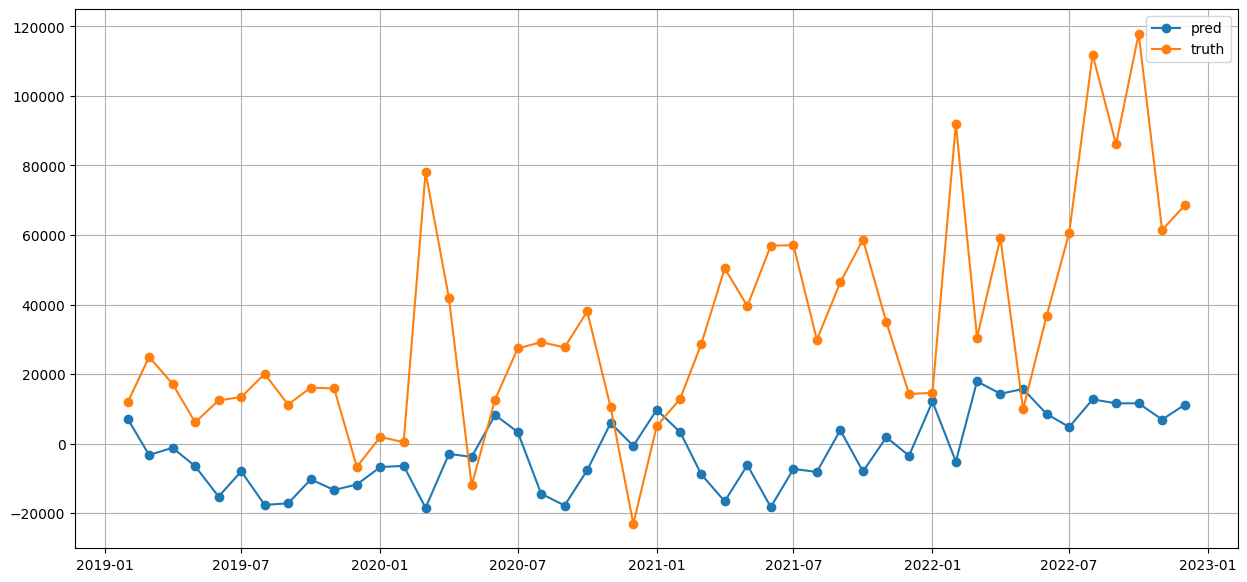

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(df.iloc[TRAIN_SIZE:]['Отчетная дата'], preds, 'o-', label='pred')
plt.plot(df.iloc[TRAIN_SIZE:]['Отчетная дата'], df.iloc[TRAIN_SIZE:]['y'], 'o-', label='truth')
plt.grid()
plt.legend()
print('MAE:', mean_absolute_error(preds, df.iloc[TRAIN_SIZE:]['y'].to_numpy()))

In [14]:
model.save_model('best-model.cbm')